<a href="https://colab.research.google.com/github/NehaP92/dsc-capstone-project-v2-onl01-dtsc-pt-041320/blob/master/Capstone_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Import Libraries

In [1]:
import numpy as np
import tensorflow as tf

np.random.seed(0)
tf.random.set_seed(0)

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os, sys, glob, shutil
import datetime as dt
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.utils import class_weight
import time
from IPython.display import Image, display
from PIL import Image as Im

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import models, layers, optimizers, regularizers
from tensorflow.keras.applications import VGG19, InceptionV3, DenseNet121, VGG16, Xception
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications.imagenet_utils import decode_predictions

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score

In [5]:
!pip install lime

In [6]:
import lime
from lime import lime_image
import random
from skimage.segmentation import mark_boundaries

## Fuctions Used

In [7]:
def unzip(folder_loc,f_name):
  
  """
  Copies a zipped folder from the folder path in google drive and unzips in the loca Colab directory
  ---------------------------------
  Input:
  folder_loc (str): zipped folder location in google drive
  f_name (str): zipped folder name
  ---------------------------------
  Output:
  Folder unzipped in Colab directory
  """

  zipped_folder = folder_loc
  fname = f_name
  !cp "{zipped_folder}" .
  !unzip -q "{fname}" 
  !rm "{fname}"

In [8]:
def conv_base(base_model='', weights='imagenet', include_top=False,input_shape=(256, 256, 3), kws={}):
  """
  Creates a transfer model base for VGG16, Xception, and DenseNet121 pretrained model
  ----------------------------------
  Input:
  base_model (str): pre-trained transfer model to be loaded. Accepte values: VGG16, Xception, and DenseNet121
  weights (str): None (random initialization), 'imagenet' (pre-training on ImageNet), or the path to the weights file to be loaded
  include_top (bool): if True, includes 3 fully connected layer on the top
  input_shape (tuple): to be included if input shape is False. Else, defaults for each pre-trained model
  ----------------------------------
  Output:
  base layers of the pretrained model
  ----------------------------------
  tensorflow.keras.applications.VGG16 DOCSTRING (For Available kws):
  tensorflow.keras.applications.Xception DOCSTRING (For Available kws):
  tensorflow.keras.applications.DenseNet121 DOCSTRING (For Available kws):
  """

  if base_model == 'VGG16':
    conv_base = VGG16(weights=weights,include_top=include_top,input_shape=input_shape,**kws)
    conv_base.trainable = False
  
  if base_model == 'Xception':
    conv_base = Xception(weights=weights,include_top=include_top,input_shape=input_shape,**kws)
    conv_base.trainable = False
  
  if base_model == 'DenseNet121':
    conv_base = VGG16(weights=weights,include_top=include_top,input_shape=input_shape,**kws)
    conv_base.trainable = False
  
  return conv_base

conv_base.__doc__+=tf.keras.applications.VGG16.__doc__
conv_base.__doc__+=tf.keras.applications.Xception.__doc__
conv_base.__doc__+=tf.keras.applications.DenseNet121.__doc__


In [9]:
def transfer_model(conv_base, learning_rate=0.001, dense_layers={},
                   dense_layer_activation='relu', final_layer_activation='softmax',
                   optimizer='Adam', metrics=['acc'], kws={}):
  """
  Builds on the pre-trained base model
  -----------------------------------
  Input:
  conv_base (keras pre-trained model): model base created from the conv_base function
  learning_rate (int): learning rate for the optimizer
  dense_layers (dict): in the form {layer number: number of features in this layer}
  dense_layer_acivation (str): defaulted to 'relu'
  final_layer_activation (str): defaulted to 'softmax'
  optimizer (str): either 'Adam' or 'RMSProp'for model compile
  metrics (list): list of performance measures
  -----------------------------------
  Output:
  Keras Model
  -----------------------------------
  tf.keras.layers.Dense DOCSTRING (For Available kws):
  """
  
  model = models.Sequential()
  model.add(conv_base)
  model.add(layers.Flatten())

  for key,value in dense_layers.items():
    model.add(layers.Dense(value, activation=dense_layer_activation,**kws))
  
  model.add(layers.Dense(5, activation=final_layer_activation,**kws))

  if optimizer == 'Adam':
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.Adam(lr=learning_rate),
                  metrics=metrics)
  
  return model

transfer_model.__doc__+=tf.keras.layers.Dense.__doc__

In [10]:
def transfer_model(conv_base, learning_rate=0.001, dense_layers={},
                   dense_layer_activation='relu', final_layer_activation='softmax',
                   optimizer='Adam', metrics=['acc'],kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                   LeakyReLU=False, LeakyReLU_alpha=0.2, Dropout=False, Dropout_rate=0.2):
  
  """
  Builds on the pre-trained base model
  -----------------------------------
  Input:
  conv_base (keras pre-trained model): model base created from the conv_base function
  learning_rate (int): learning rate for the optimizer
  dense_layers (dict): in the form {layer number: number of features in this layer}
  dense_layer_acivation (str): defaulted to 'relu'
  final_layer_activation (str): defaulted to 'softmax'
  optimizer (str): either 'Adam' or 'RMSProp'for model compile
  metrics (list): list of performance measures
  -----------------------------------
  Output:
  Keras Model
  """
  
  model = models.Sequential()
  model.add(conv_base)
  model.add(layers.Flatten())

  for key,value in dense_layers.items():
    model.add(layers.Dense(value, activation=dense_layer_activation))
    if LeakyReLU:
      model.add(layers.LeakyReLU(alpha=LeakyReLU_alpha))
    if Dropout:
      model.add(layers.Dropout(Dropout_rate))
  
  model.add(layers.Dense(5, activation=final_layer_activation))

  if optimizer == 'Adam':
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.Adam(lr=learning_rate),
                  metrics=metrics)
    
  if optimizer == 'RMSprop':
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.RMSprop(lr=learning_rate),
                  metrics=metrics)
  
  return model

In [11]:
def performance_plot(model, hist, X_test,y_test, metric=['acc']):

  """
  Gives a performance analysis of the trained keras model by loss curves, different metric curves, and
  printing the classification report and a visual representation of the confusion matrix
  ----------------------------------------
  Input:
  model (keras model)
  hist: trained result of the model
  X_test,y_test: test data
  metric (list): list of performance measures
  ----------------------------------------
  Output:
  performance curves, training and validation
  loss curve, training and validation
  classification report
  confusion metrics
  """
  
  hist_df = pd.DataFrame(hist.history)

  if len(metric)>1:
    fig,axes = plt.subplots(ncols=1, nrows = len(metric),figsize=(8,len(metric)*5))
    axes=axes.flatten()
    for i,m in enumerate(metric):
      hist_df[[m,f'val_{m}']].plot(marker='o',ax=axes[i])
      plt.show();
  else:
    axa = hist_df[[metric[0],f'val_{metric[0]}']].plot(marker='o')
    plt.show()
  
  axl = hist_df[['loss','val_loss']].plot(marker='o')
  plt.show();

  y_pred=model.predict(X_test)
  print(metrics.classification_report(y_test.argmax(axis=1),y_pred.argmax(axis=1)))

  conf_matrix = metrics.confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1),normalize = 'true')
  ax = sns.heatmap(conf_matrix, cmap='Reds', annot=True, square=True)
  ax.set(xlabel='Predicted Class', ylabel='True Class')
  ax.set_ylim(5, 0)
  ax.set(title='Covid: 0 Normal: 1, Pneumonia: 2 TB: 3, TB_Normal: 4')
  plt.show();


In [12]:
def early_stopping(monitor='val_loss', patience=3,mode='auto',
                   restore_best_weights=False,kws={}):
  
  """
  Used to stop the training once the given conditions are met
  -----------------------------------------
  Input:
  monitor (str): select the value to monitor for early stopping. default: 'val_loss'
  patience (int): try these many more steps before stopping
  -----------------------------------------
  tf.keras.layers.callbacks DOCSTRING (For Available kws):
  """

  par = EarlyStopping(monitor=monitor, patience=patience,mode=mode,
                      restore_best_weights=restore_best_weights, **kws)
  
  return par

early_stopping.__doc__+=tf.keras.callbacks.__doc__

In [37]:
def train_model(model, X_train,y_train,epochs=50,batch_size=64,validation_data=(X_val,y_val),
                class_weight= class_weights, callbacks=early_stopping()):
  
  """
  Trains the keras model
  ------------------------------------
  Input:
  model: keras model
  X_train,y_train: training data
  epochs (int): number of steps
  batch_size (int): batch size for each epoch
  validation_data
  class_weights (dic): in the form {class: weights}
  callbacks: earlystopping function
  ------------------------------------
  Output:
  Trained result of the model
  -------------------------------------
  """

  hist = model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,validation_data=validation_data, class_weight= class_weight,
                   callbacks=callbacks)
  return hist

In [38]:
def bad_pred_lime(model,X_test,y_test,total_out=5):

  """
  Prints the number of bad predictions and visually represents the area of the 
  image that was analysed for these predictions for each class
  ----------------------------------------------
  Input:
  model: keras model
  X_test,y_test: test data
  total_out: total number of bad predictions to be visually represented
  ----------------------------------------------
  Output:
  Total number of bad predictions
  Visual representation of the area investigated for these results for each class
  """
  
  y_pred=model.predict(X_test)
  bad_pred = (np.round(y_pred,3).argmax(axis=1) !=y_test.argmax(axis=1))
  print('Bad predictions:', sum(bad_pred))

  indecies = np.random.choice(range(sum(bad_pred)),total_out)

  explainer=lime_image.LimeImageExplainer(random_state=7)

  fig, ax = plt.subplots(total_out, 6, sharex='col', sharey='row')
  fig.set_figwidth(20)
  fig.set_figheight(16)
  for j in range(5):
    explanation = explainer.explain_instance(X_test[bad_pred][indecies[j]],model.predict,hide_color=0,random_seed=7)
    ax[j,0].imshow(X_test[bad_pred][indecies[j]])
    if y_test[bad_pred][indecies[j]][0] == 1:
      title="COVID : 0"
    if y_test[bad_pred][indecies[j]][1] == 1:
      title="Normal : 1"
    if y_test[bad_pred][indecies[j]][2] == 1:
      title="TB : 2"
    if y_test[bad_pred][indecies[j]][3] == 1:
      title="TB_Normal : 3"
    if y_test[bad_pred][indecies[j]][4] == 1:
      title="Viral Pneumonia : 4"
    ax[j,0].set_title(title)
    

    for i in range(5):
          temp, mask = explanation.get_image_and_mask(i, positive_only=True, 
                                                      num_features=5, hide_rest=True)
          ax[j,i+1].imshow(mark_boundaries(temp / 2 + 0.5, mask))
          
          classes=['COVID','NORMAL','TB','TB_NORMAL','VIRAL_PNEUMONIA']
          ax[j,i+1].set_title('p({}) = {:.4f}'.format(classes[i], y_pred[bad_pred][indecies[j]][i]))



In [39]:
def lime(model,X_test,y_test,total_out=5):

  """
  Visually represents the area of the image that was analysed for predicting each class
  ----------------------------------------------
  Input:
  model: keras model
  X_test,y_test: test data
  total_out: total number of predictions to be visually represented
  ----------------------------------------------
  Output:
  Visual representation of the area investigated for these results for each class
  """

  y_pred=model.predict(X_test)

  indecies=np.random.choice(range(len(X_test)),total_out)

  explainer=lime_image.LimeImageExplainer(random_state=7)

  fig, ax = plt.subplots(total_out, 6, sharex='col', sharey='row')
  fig.set_figwidth(20)
  fig.set_figheight(16)
  
  for j in range(5):
      explanation = explainer.explain_instance(X_test[indecies[j]], model.predict, 
                                              top_labels=5, hide_color=0, num_samples=1000, 
                                              random_seed=7)
      ax[j,0].imshow(X_test[indecies[j]])

      if y_test[indecies[j]][0] == 1:
        title="COVID : 0"
      if y_test[indecies[j]][1] == 1:
        title="Normal : 1"
      if y_test[indecies[j]][2] == 1:
        title="TB : 2"
      if y_test[indecies[j]][3] == 1:
        title="TB_Normal : 3"
      if y_test[indecies[j]][4] == 1:
        title="Viral Pneumonia : 4"

      ax[j,0].set_title(title)

    
      for i in range(5):
          temp, mask = explanation.get_image_and_mask(i, positive_only=True, 
                                                      num_features=5, hide_rest=True)
          ax[j,i+1].imshow(mark_boundaries(temp / 2 + 0.5, mask))

          classes=['COVID','NORMAL','TB','TB_NORMAL','VIRAL_PNEUMONIA']
          ax[j,i+1].set_title('p({}) = {:.4f}'.format(classes[i], y_pred[indecies[j]][i]))  
  


## Business Case

The outbreak of Novel Coronavirus (SARS-COV-2) has taken over all our lives ever since the pandemic hit last year. The difficult part at the beginning of the outbreak was to detect the virus since the symptoms are shared among other common desieses and infections. One of these include pneumonia.

> Deep learning AI models have been used in the past to detect pneumonia, and have been reported to gain about 90% accuracy. [1]

While discussing about pneumonia, it is paramount to understand that pneumonia is often misdiagnosed as tuberculosis. [2]

This project explores building different models that would detect if a lung X-Ray correctly diagnoses COVID-19, Pneumonia, Tuberculosis, Viral Pneumonia, or if it is a normal Chest X-ray. It also explores the varios regions of the x-ray that the model is looking in for an accurate diagnosis.

> Accuracy, Precision, and Recall have been used as the deciding factor for the best model

Precision would be important when the model is used to distinguish between the different desieses whoes diagnosis are often confused with another, while recall becomes significant while determining if the desiese is present at all.

## Data Processing

In [14]:
root_dir = "/content/gdrive/MyDrive/Data Science/Capstone Data"

In [15]:
dir_list = os.listdir(root_dir)


In [16]:
dir_list

['img_labels.csv',
 'Combined',
 'img_labels_colab.csv',
 'Combined_50',
 'Combined_50-20210129T000224Z-001.zip',
 'img_labels_colab_50.csv',
 'Combined-20210130T220345Z-003.zip',
 'Combined-20210130T220345Z-002.zip',
 'Combined-20210130T220345Z-001.zip',
 'img_labels_colab_local.csv']

In [20]:
unzip("/content/gdrive/MyDrive/Data Science/Capstone Data/Combined-20210130T220345Z-003.zip",'Combined-20210130T220345Z-003.zip')

In [21]:
unzip("/content/gdrive/MyDrive/Data Science/Capstone Data/Combined-20210130T220345Z-002.zip",'Combined-20210130T220345Z-002.zip')

In [22]:
unzip("/content/gdrive/MyDrive/Data Science/Capstone Data/Combined-20210130T220345Z-001.zip",'Combined-20210130T220345Z-001.zip')

In [20]:
len(os.listdir("/content/gdrive/MyDrive/Data Science/Capstone Data/Combined"))

4687

In [21]:
dir_list

['img_labels.csv',
 'Combined',
 'img_labels_colab.csv',
 'Combined_50',
 'Combined_50-20210129T000224Z-001.zip',
 'img_labels_colab_50.csv',
 'Combined-20210130T220345Z-003.zip',
 'Combined-20210130T220345Z-002.zip',
 'Combined-20210130T220345Z-001.zip',
 'img_labels_colab_local.csv']

In [17]:
files=[]
total_img=0
for i in enumerate(dir_list[1:2]):
    folder_loc=os.path.join(root_dir,i[1])
    for j in os.listdir(folder_loc):
        files.append(j)
    total_img+=len(os.listdir(folder_loc))
print(total_img)
print(len(files))

4687
4687


In [18]:
colab_list = os.listdir("/content/Combined")

In [19]:
colab_dir = os.listdir("/content")
colab_dir

['.config', 'gdrive', 'Combined', 'sample_data']

In [20]:
datagen = ImageDataGenerator(rescale = 1./255)

In [21]:
df_img = pd.read_csv('/content/gdrive/MyDrive/Data Science/Capstone Data/img_labels_colab_local.csv',header=None)
df_img.columns = ['file','category']
df_img

file  category
0                 /content/Combined/COVID_0.png         0
1                 /content/Combined/COVID_1.png         0
2                /content/Combined/COVID_10.png         0
3               /content/Combined/COVID_100.png         0
4              /content/Combined/COVID_1000.png         0
...                                         ...       ...
4682  /content/Combined/Viral Pneumonia_995.png         4
4683  /content/Combined/Viral Pneumonia_996.png         4
4684  /content/Combined/Viral Pneumonia_997.png         4
4685  /content/Combined/Viral Pneumonia_998.png         4
4686  /content/Combined/Viral Pneumonia_999.png         4

[4687 rows x 2 columns]

In [22]:
cat_map = {0: 'Covid', 1: 'Normal', 2:'TB', 3:'TB_Normal',4:'Pneumonia'}
df_img['Category_name']=df_img['category'].map(cat_map)
df_img

file  category Category_name
0                 /content/Combined/COVID_0.png         0         Covid
1                 /content/Combined/COVID_1.png         0         Covid
2                /content/Combined/COVID_10.png         0         Covid
3               /content/Combined/COVID_100.png         0         Covid
4              /content/Combined/COVID_1000.png         0         Covid
...                                         ...       ...           ...
4682  /content/Combined/Viral Pneumonia_995.png         4     Pneumonia
4683  /content/Combined/Viral Pneumonia_996.png         4     Pneumonia
4684  /content/Combined/Viral Pneumonia_997.png         4     Pneumonia
4685  /content/Combined/Viral Pneumonia_998.png         4     Pneumonia
4686  /content/Combined/Viral Pneumonia_999.png         4     Pneumonia

[4687 rows x 3 columns]

In [23]:
image_set = datagen.flow_from_dataframe(dataframe=df_img,
                                        directory='/',
                                        x_col = 'file',
                                        y_col = 'Category_name',
                                        batch_size=4687,
                                        )

Found 4687 validated image filenames belonging to 5 classes.


In [24]:
# X,y = next(image_set)

**A corrupt image was found in row 2870**

In [25]:
df_img_updated = df_img.copy().drop(index=2869)
df_img_updated

file  category Category_name
0                 /content/Combined/COVID_0.png         0         Covid
1                 /content/Combined/COVID_1.png         0         Covid
2                /content/Combined/COVID_10.png         0         Covid
3               /content/Combined/COVID_100.png         0         Covid
4              /content/Combined/COVID_1000.png         0         Covid
...                                         ...       ...           ...
4682  /content/Combined/Viral Pneumonia_995.png         4     Pneumonia
4683  /content/Combined/Viral Pneumonia_996.png         4     Pneumonia
4684  /content/Combined/Viral Pneumonia_997.png         4     Pneumonia
4685  /content/Combined/Viral Pneumonia_998.png         4     Pneumonia
4686  /content/Combined/Viral Pneumonia_999.png         4     Pneumonia

[4686 rows x 3 columns]

In [26]:
image_set = datagen.flow_from_dataframe(dataframe=df_img_updated,
                                        directory='/',
                                        x_col = 'file',
                                        y_col = 'Category_name',
                                        batch_size=4687,
                                        )

Found 4686 validated image filenames belonging to 5 classes.


In [27]:
X,y = next(image_set)

In [28]:
X_train,X_test,y_train,y_test = train_test_split(X, y,test_size = 0.1,random_state = 7)
X_train,X_val,y_train,y_val = train_test_split(X_train, y_train,test_size = 0.1,random_state = 7)

In [29]:
X_test.shape

(469, 256, 256, 3)

In [30]:
X_test.shape[1:]

(256, 256, 3)

TB : 2


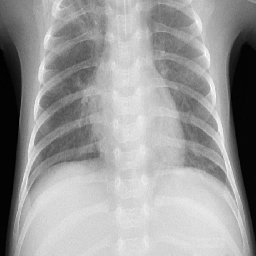

In [31]:
i=np.random.choice(range(len(X)))
if y[i][0] == 1:
  print ("COVID : 0")
if y[i][1] == 1:
  print ("Normal : 1")
if y[i][2] == 1:
  print ("TB : 2")
if y[i][3] == 1:
  print ("TB_Normal : 3")
if y[i][4] == 1:
  print ("Viral Pneumonia : 4")
display(array_to_img(X[i]))

In [32]:
def random_image(X,y):
  i=np.random.choice(range(len(X)))
  if y[i][0] == 1:
    print ("COVID : 0")
  if y[i][1] == 1:
    print ("Normal : 1")
  if y[i][2] == 1:
    print ("TB : 2")
  if y[i][3] == 1:
    print ("TB_Normal : 3")
  if y[i][4] == 1:
    print ("Viral Pneumonia : 4")
  display(array_to_img(X[i]))

Normal : 1


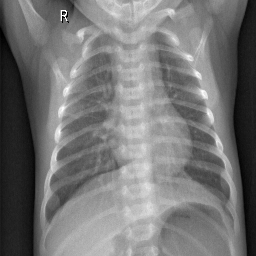

In [33]:
random_image(X,y)

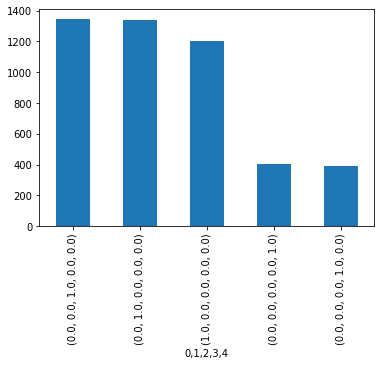

In [34]:
pd.DataFrame(y).value_counts().plot(kind="bar")

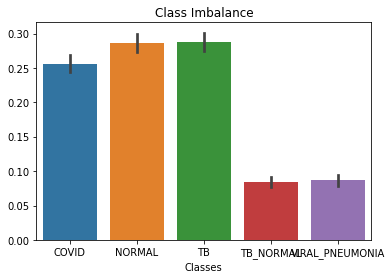

In [40]:
y_df = pd.DataFrame(y,columns=['COVID','NORMAL','TB','TB_NORMAL','VIRAL_PNEUMONIA'])
ax = sns.barplot(data=y_df)
ax.set_title('Class Imbalance')
ax.set_xlabel('Classes');

In [35]:
classes = [0,1,2,3,4]

In [36]:
class_weights = class_weight.compute_class_weight('balanced', classes, y_train.argmax(axis=1))
class_weights = dict(zip(classes,class_weights))
class_weights

{0: 0.7947643979057591,
 1: 0.69,
 2: 0.6937842778793418,
 3: 2.4483870967741934,
 4: 2.2589285714285716}

## Dummy Model

In [46]:
dummy = DummyClassifier()
dummy.fit(X_train,y_train)
y_pred=dummy.predict(X_val)
print(metrics.classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.30      0.26      0.28       118
           1       0.25      0.28      0.26       109
           2       0.30      0.27      0.28       123
           3       0.15      0.11      0.13        44
           4       0.03      0.04      0.04        28

   micro avg       0.25      0.24      0.24       422
   macro avg       0.20      0.19      0.20       422
weighted avg       0.25      0.24      0.24       422
 samples avg       0.17      0.24      0.19       422



/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
score = balanced_accuracy_score(y_val.argmax(axis=1), y_pred.argmax(axis=1))
print (score)
# metrics.plot_confusion_matrix(dummy, X_train, y_train, normalize='true')

0.1819071586342162


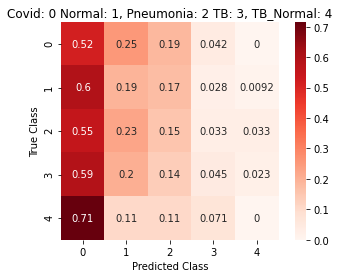

In [49]:
cm=metrics.confusion_matrix(y_val.argmax(axis=1),y_pred.argmax(axis=1),normalize = 'true')
ax = sns.heatmap(cm, cmap='Reds', annot=True, square=True)
ax.set(xlabel='Predicted Class', ylabel='True Class')
ax.set_ylim(5, 0)
ax.set(title='Covid: 0 Normal: 1, Pneumonia: 2 TB: 3, TB_Normal: 4')
plt.show();

## Pre-trained Model VGG16

In [61]:
conv_base_vgg16 = conv_base('VGG16')

58892288/58889256 [==============================] - 1s 0us/step


### VGG16 Base: 1 Layer, No Class Weights

Class weights: None\
Additional layers: 1\
Optimizer: Adam\
epochs: 20\
batch_size: 100
Callbacks: None

In [62]:
model_vgg16 = transfer_model(conv_base=conv_base_vgg16,learning_rate=0.001,dense_layers={1:256},kernel_regularizer=None, bias_regularizer=None)

In [63]:
hist_vgg16 = model_vgg16.fit(X_train,y_train,epochs=20,batch_size=100,validation_data=(X_val,y_val))

Epoch 1/20
38/38 [==============================] - 36s 663ms/step - loss: 3.3528 - acc: 0.5787 - val_loss: 0.2226 - val_acc: 0.9100
Epoch 2/20
38/38 [==============================] - 21s 558ms/step - loss: 0.1909 - acc: 0.9325 - val_loss: 0.2111 - val_acc: 0.9147
Epoch 3/20
38/38 [==============================] - 22s 580ms/step - loss: 0.1398 - acc: 0.9554 - val_loss: 0.1435 - val_acc: 0.9431
Epoch 4/20
38/38 [==============================] - 22s 567ms/step - loss: 0.0957 - acc: 0.9701 - val_loss: 0.1257 - val_acc: 0.9479
Epoch 5/20
38/38 [==============================] - 21s 556ms/step - loss: 0.0626 - acc: 0.9837 - val_loss: 0.1500 - val_acc: 0.9384
Epoch 6/20
38/38 [==============================] - 21s 560ms/step - loss: 0.0534 - acc: 0.9874 - val_loss: 0.1221 - val_acc: 0.9526
Epoch 7/20
38/38 [==============================] - 21s 566ms/step - loss: 0.0330 - acc: 0.9946 - val_loss: 0.1309 - val_acc: 0.9550
Epoch 8/20
38/38 [==============================] - 21s 566ms/step - 

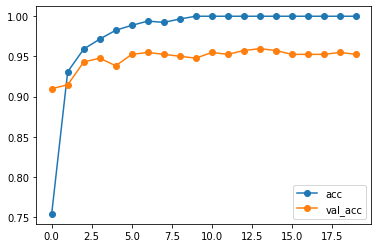

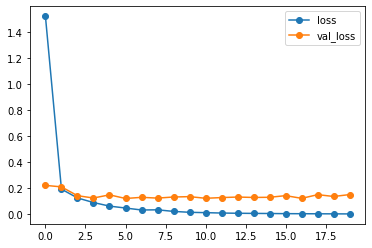

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       127
           1       0.97      1.00      0.99       132
           2       0.99      0.95      0.97       128
           3       0.92      0.85      0.88        40
           4       0.86      0.90      0.88        42

    accuracy                           0.96       469
   macro avg       0.94      0.94      0.94       469
weighted avg       0.96      0.96      0.96       469



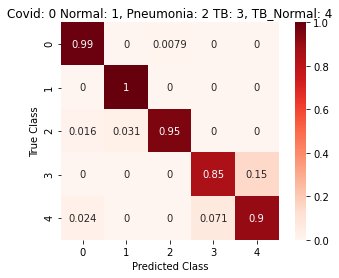

In [64]:
performance_plot(model=model_vgg16, hist=hist_vgg16, X_test=X_test,y_test=y_test,metric=['acc'])

Bad predictions: 17


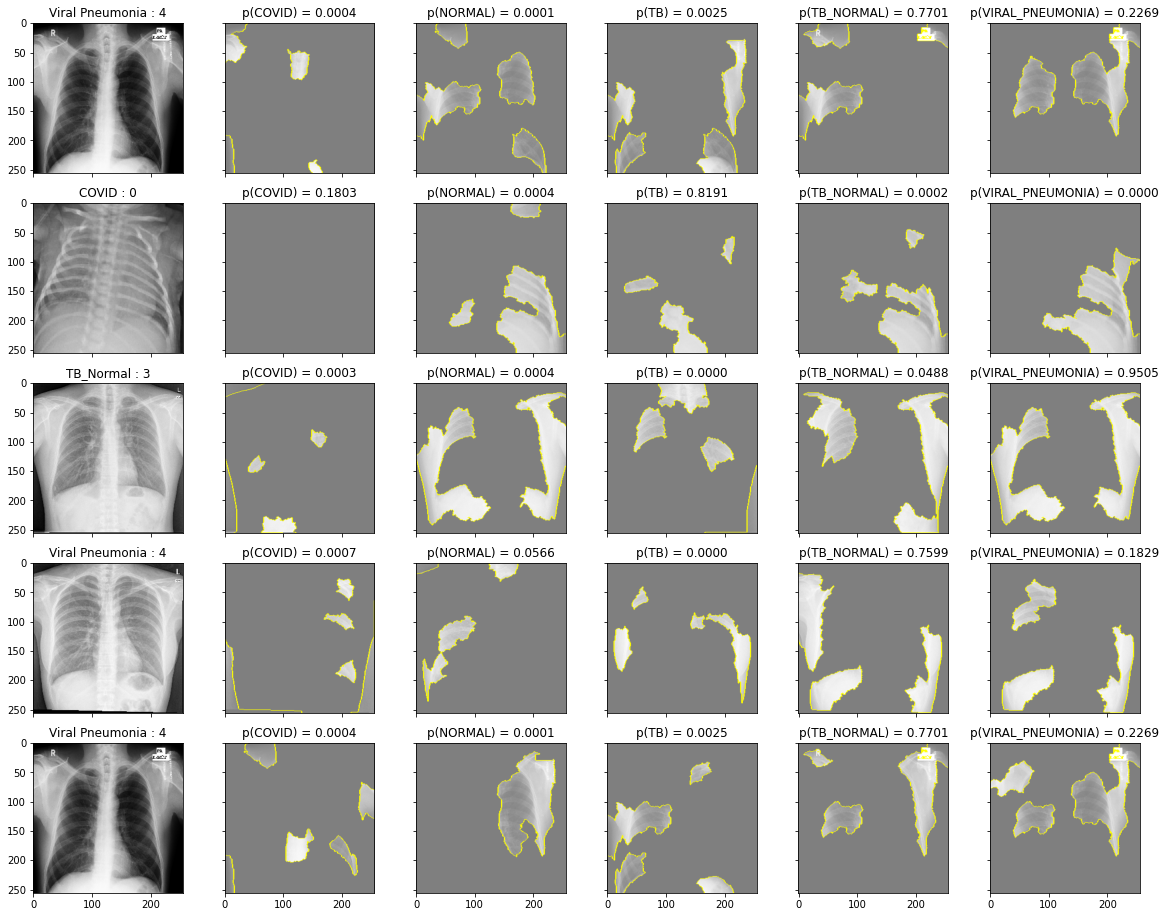

In [66]:
bad_pred_lime(model_vgg16,X_test,y_test)

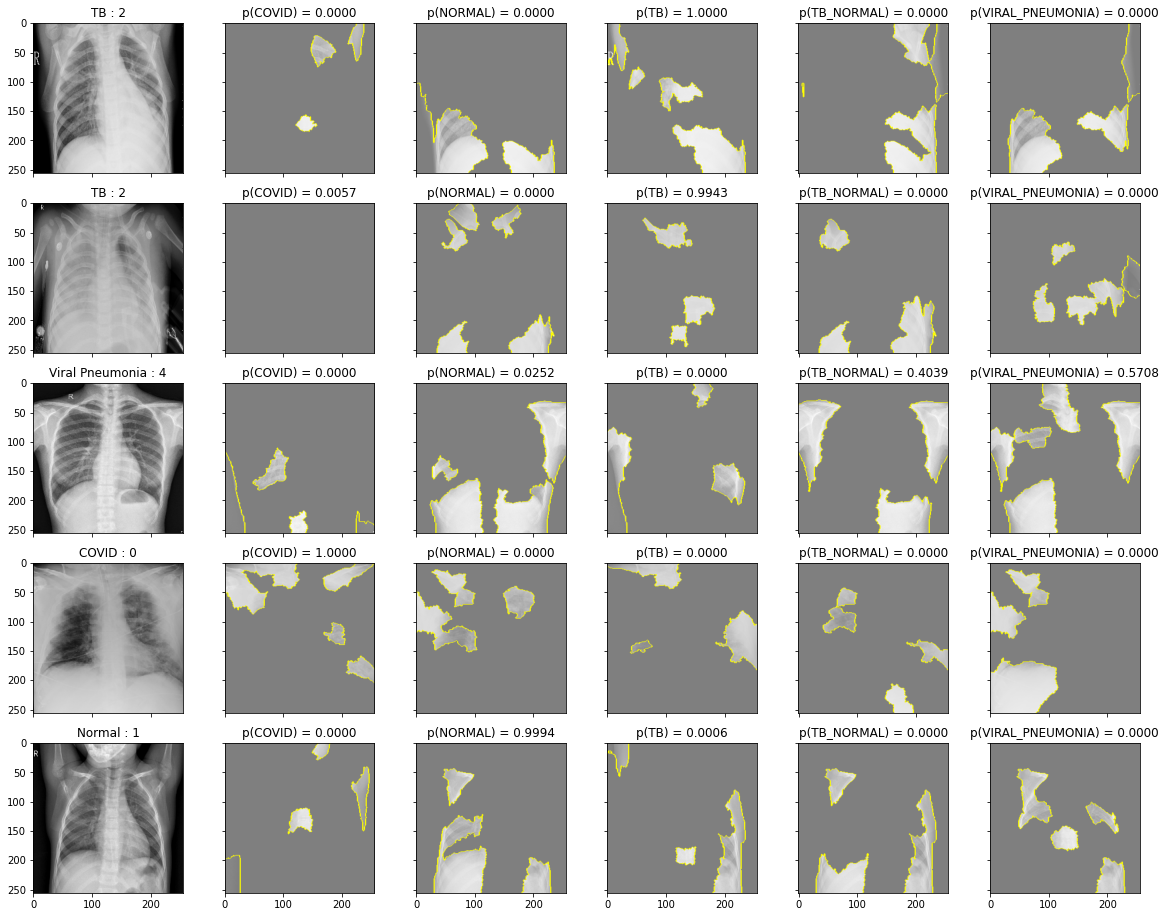

In [69]:
lime(model_vgg16,X_test,y_test)

#### With EarlyStopping

In [70]:
model_vgg16_3 = transfer_model(conv_base_vgg16,dense_layers={1:256})

In [71]:
hist_vgg16_3=train_model(model_vgg16_3,X_train,y_train, class_weight=None)

Epoch 1/50
60/60 [==============================] - 26s 383ms/step - loss: 3.6735 - acc: 0.6031 - val_loss: 0.3152 - val_acc: 0.8981
Epoch 2/50
60/60 [==============================] - 20s 341ms/step - loss: 0.1913 - acc: 0.9293 - val_loss: 0.1977 - val_acc: 0.9218
Epoch 3/50
60/60 [==============================] - 20s 329ms/step - loss: 0.1295 - acc: 0.9497 - val_loss: 0.1419 - val_acc: 0.9502
Epoch 4/50
60/60 [==============================] - 20s 326ms/step - loss: 0.0828 - acc: 0.9759 - val_loss: 0.1844 - val_acc: 0.9194
Epoch 5/50
60/60 [==============================] - 20s 328ms/step - loss: 0.0685 - acc: 0.9729 - val_loss: 0.1195 - val_acc: 0.9502
Epoch 6/50
60/60 [==============================] - 20s 331ms/step - loss: 0.0385 - acc: 0.9921 - val_loss: 0.1430 - val_acc: 0.9384
Epoch 7/50
60/60 [==============================] - 20s 331ms/step - loss: 0.0329 - acc: 0.9937 - val_loss: 0.1335 - val_acc: 0.9455
Epoch 8/50
60/60 [==============================] - 20s 330ms/step - 

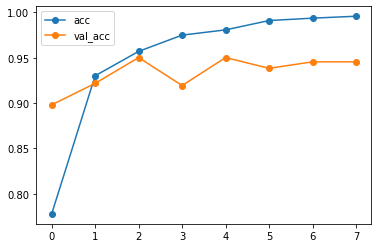

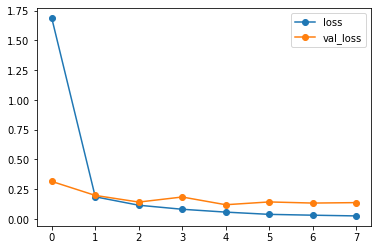

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       127
           1       0.96      1.00      0.98       132
           2       0.99      0.94      0.96       128
           3       0.67      0.97      0.80        40
           4       0.95      0.50      0.66        42

    accuracy                           0.93       469
   macro avg       0.91      0.88      0.87       469
weighted avg       0.95      0.93      0.93       469



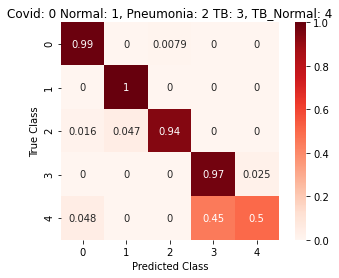

In [74]:
performance_plot(model = model_vgg16_3,hist=hist_vgg16_3, X_test=X_test,y_test=y_test)

### VGG16 Model 2: 1 Layer, Including Class Weights

Additional layers: 1\
Optimizer: Adam\
epochs: 50\
batch_size: 64
Callbacks: EarlyStopping

In [76]:
model_vgg16_4 = transfer_model(conv_base_vgg16,dense_layers={1:256})

In [77]:
hist_vgg16_4 = train_model(model_vgg16_4,X_train,y_train)

Epoch 1/50
60/60 [==============================] - 21s 338ms/step - loss: 2.2972 - acc: 0.5988 - val_loss: 0.4173 - val_acc: 0.8697
Epoch 2/50
60/60 [==============================] - 20s 342ms/step - loss: 0.3183 - acc: 0.9163 - val_loss: 0.1588 - val_acc: 0.9360
Epoch 3/50
60/60 [==============================] - 20s 330ms/step - loss: 0.1625 - acc: 0.9611 - val_loss: 0.1453 - val_acc: 0.9408
Epoch 4/50
60/60 [==============================] - 20s 326ms/step - loss: 0.1463 - acc: 0.9663 - val_loss: 0.1988 - val_acc: 0.9242
Epoch 5/50
60/60 [==============================] - 20s 328ms/step - loss: 0.1562 - acc: 0.9668 - val_loss: 0.1268 - val_acc: 0.9455
Epoch 6/50
60/60 [==============================] - 20s 334ms/step - loss: 0.0757 - acc: 0.9863 - val_loss: 0.1293 - val_acc: 0.9502
Epoch 7/50
60/60 [==============================] - 20s 332ms/step - loss: 0.0523 - acc: 0.9903 - val_loss: 0.1439 - val_acc: 0.9408
Epoch 8/50
60/60 [==============================] - 20s 330ms/step - 

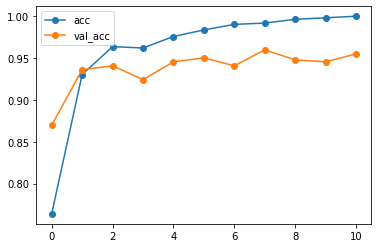

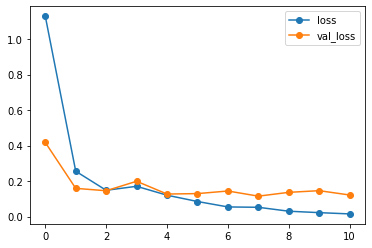

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       127
           1       0.98      0.99      0.99       132
           2       0.98      0.97      0.98       128
           3       0.90      0.90      0.90        40
           4       0.90      0.88      0.89        42

    accuracy                           0.97       469
   macro avg       0.95      0.95      0.95       469
weighted avg       0.97      0.97      0.97       469



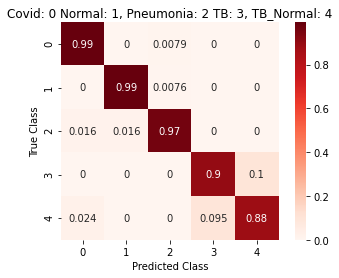

In [78]:
performance_plot(model = model_vgg16_4,hist=hist_vgg16_4, X_test=X_test,y_test=y_test)

Bad predictions: 15


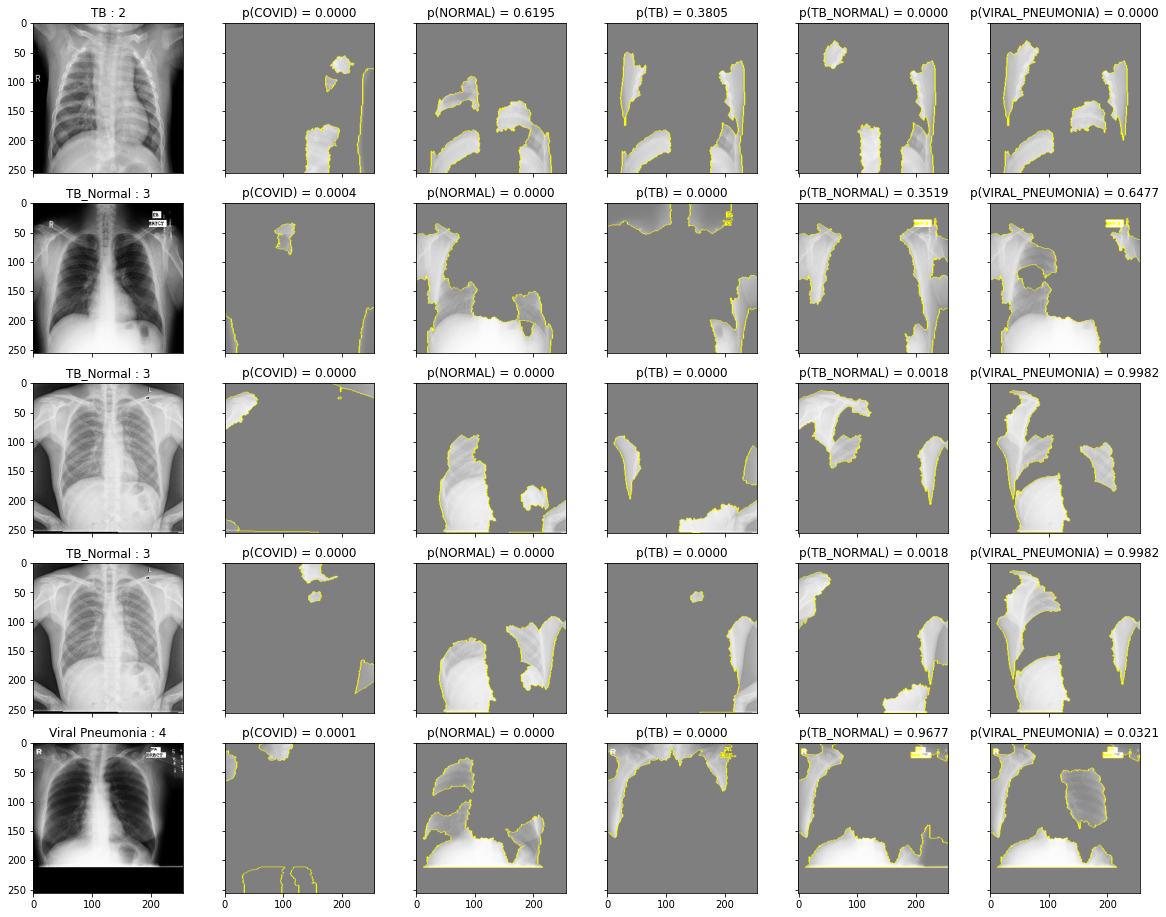

In [79]:
bad_pred_lime(model_vgg16_4,X_test,y_test)

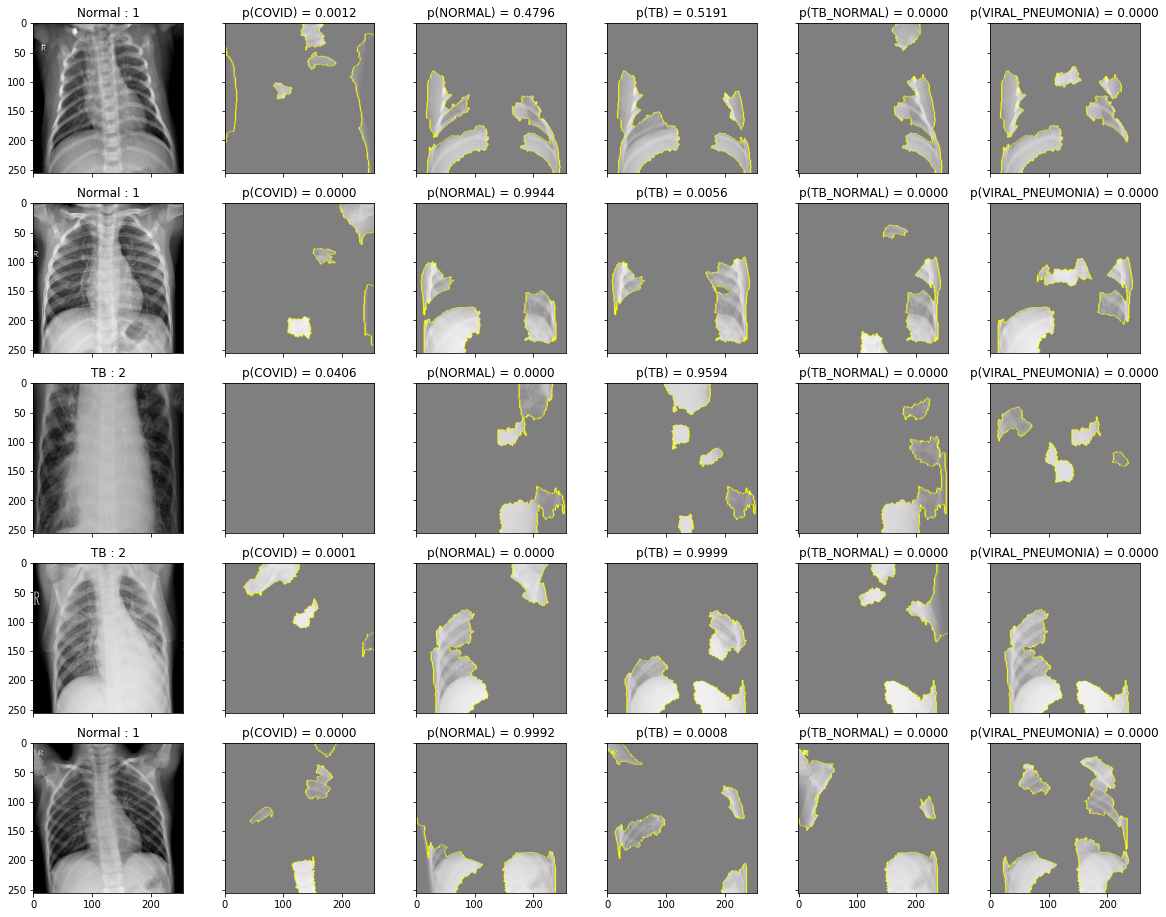

In [80]:
lime(model_vgg16_4,X_test,y_test)

### VGG16 Model 3: Additional Layers and Different Optimizers

#### Model 3a

Layers: 5\
Optimizer RMSProp

In [81]:
model_m1 = transfer_model(conv_base_vgg16,dense_layers={1:4000,2:2000,3:1000,4:500,5:256},optimizer='RMSprop')

In [82]:
hist_m1 = train_model(model_m1,X_train,y_train)

Epoch 1/50
60/60 [==============================] - 25s 408ms/step - loss: 43.2650 - acc: 0.2530 - val_loss: 1.6052 - val_acc: 0.6137
Epoch 2/50
60/60 [==============================] - 24s 405ms/step - loss: 1.1269 - acc: 0.5909 - val_loss: 1.2002 - val_acc: 0.4668
Epoch 3/50
60/60 [==============================] - 23s 392ms/step - loss: 0.6916 - acc: 0.7771 - val_loss: 0.3564 - val_acc: 0.8460
Epoch 4/50
60/60 [==============================] - 23s 391ms/step - loss: 0.4227 - acc: 0.8774 - val_loss: 0.3588 - val_acc: 0.8483
Epoch 5/50
60/60 [==============================] - 24s 397ms/step - loss: 0.4236 - acc: 0.8707 - val_loss: 0.3739 - val_acc: 0.8791
Epoch 6/50
60/60 [==============================] - 24s 397ms/step - loss: 0.4737 - acc: 0.8858 - val_loss: 0.2198 - val_acc: 0.9147
Epoch 7/50
60/60 [==============================] - 24s 394ms/step - loss: 0.2954 - acc: 0.9303 - val_loss: 0.3228 - val_acc: 0.8981
Epoch 8/50
60/60 [==============================] - 24s 394ms/step -

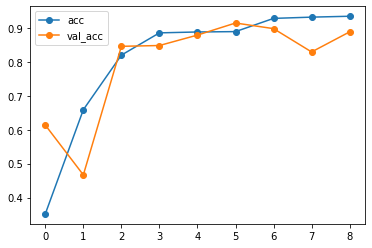

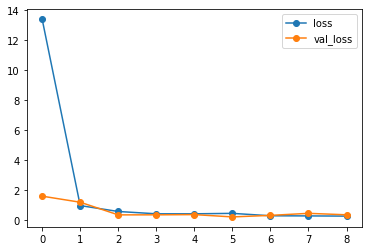

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       127
           1       1.00      0.67      0.80       132
           2       0.74      0.98      0.84       128
           3       0.83      0.88      0.85        40
           4       0.88      0.83      0.85        42

    accuracy                           0.87       469
   macro avg       0.88      0.87      0.87       469
weighted avg       0.90      0.87      0.87       469



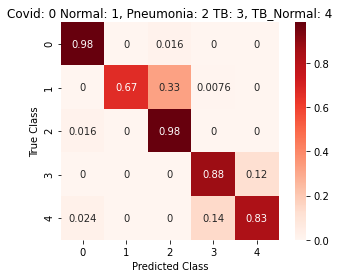

In [83]:
performance_plot(model_m1, hist_m1,X_test,y_test)

#### Model 3b

Layers: 4\
Optimizer Adam\
Dropout Layer Present

In [84]:
model_m2 = transfer_model(conv_base_vgg16,dense_layers={1:3000,2:1500,3:500,4:256},Dropout=True)

In [85]:
hist_m2 = train_model(model_m2,X_train,y_train)

Epoch 1/50
60/60 [==============================] - 22s 360ms/step - loss: 4.3681 - acc: 0.3651 - val_loss: 0.4058 - val_acc: 0.8602
Epoch 2/50
60/60 [==============================] - 21s 358ms/step - loss: 0.4095 - acc: 0.8887 - val_loss: 0.3326 - val_acc: 0.8531
Epoch 3/50
60/60 [==============================] - 21s 357ms/step - loss: 0.3519 - acc: 0.8913 - val_loss: 0.1771 - val_acc: 0.9313
Epoch 4/50
60/60 [==============================] - 22s 360ms/step - loss: 0.2730 - acc: 0.9332 - val_loss: 0.1505 - val_acc: 0.9408
Epoch 5/50
60/60 [==============================] - 21s 357ms/step - loss: 0.2148 - acc: 0.9477 - val_loss: 0.1402 - val_acc: 0.9384
Epoch 6/50
60/60 [==============================] - 21s 357ms/step - loss: 0.2334 - acc: 0.9418 - val_loss: 0.1323 - val_acc: 0.9431
Epoch 7/50
60/60 [==============================] - 21s 356ms/step - loss: 0.1604 - acc: 0.9597 - val_loss: 0.2092 - val_acc: 0.9289
Epoch 8/50
60/60 [==============================] - 21s 356ms/step - 

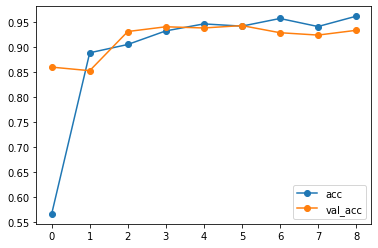

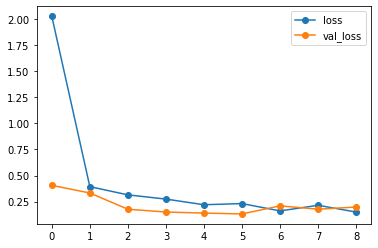

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       127
           1       0.92      1.00      0.96       132
           2       0.99      0.90      0.94       128
           3       0.92      0.82      0.87        40
           4       0.85      0.93      0.89        42

    accuracy                           0.95       469
   macro avg       0.93      0.93      0.93       469
weighted avg       0.95      0.95      0.95       469



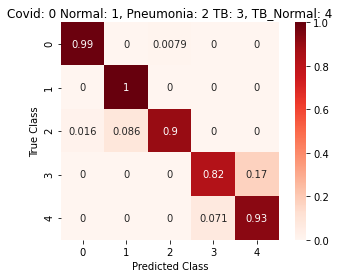

In [86]:
performance_plot(model_m2,hist_m2,X_test,y_test)

#### Model 3c

Layers: 4\
Optimizer Adam\
Dropout Layer Present\
LeakyReLu Present

In [89]:
model_m4 = transfer_model(conv_base_vgg16,dense_layers={1:3000,2:1500,3:500,4:256},LeakyReLU=True,Dropout=True)

In [90]:
hist_m4 = train_model(model_m4,X_train,y_train)

Epoch 1/50
60/60 [==============================] - 22s 360ms/step - loss: 3.8131 - acc: 0.3778 - val_loss: 0.4031 - val_acc: 0.8507
Epoch 2/50
60/60 [==============================] - 21s 357ms/step - loss: 0.4291 - acc: 0.8838 - val_loss: 0.2414 - val_acc: 0.8839
Epoch 3/50
60/60 [==============================] - 21s 357ms/step - loss: 0.3124 - acc: 0.9216 - val_loss: 0.1586 - val_acc: 0.9218
Epoch 4/50
60/60 [==============================] - 21s 357ms/step - loss: 0.2646 - acc: 0.9293 - val_loss: 0.3030 - val_acc: 0.9005
Epoch 5/50
60/60 [==============================] - 21s 357ms/step - loss: 0.2282 - acc: 0.9426 - val_loss: 0.1250 - val_acc: 0.9384
Epoch 6/50
60/60 [==============================] - 21s 357ms/step - loss: 0.2086 - acc: 0.9397 - val_loss: 0.2035 - val_acc: 0.9313
Epoch 7/50
60/60 [==============================] - 21s 357ms/step - loss: 0.2539 - acc: 0.9260 - val_loss: 0.1249 - val_acc: 0.9479
Epoch 8/50
60/60 [==============================] - 21s 357ms/step - 

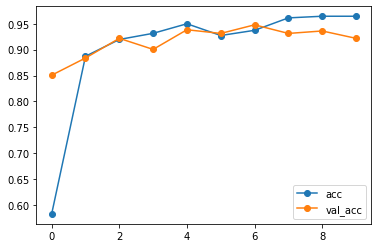

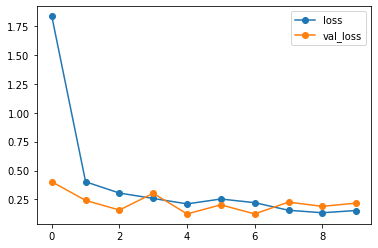

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       127
           1       0.95      0.99      0.97       132
           2       1.00      0.93      0.96       128
           3       0.83      0.85      0.84        40
           4       0.76      0.90      0.83        42

    accuracy                           0.94       469
   macro avg       0.90      0.92      0.91       469
weighted avg       0.95      0.94      0.94       469



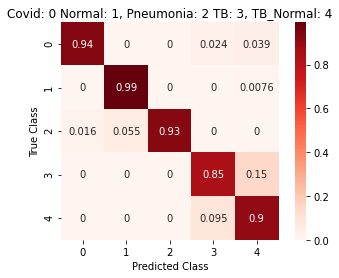

In [91]:
performance_plot(model_m4,hist_m4,X_test,y_test)

Bad predictions: 28


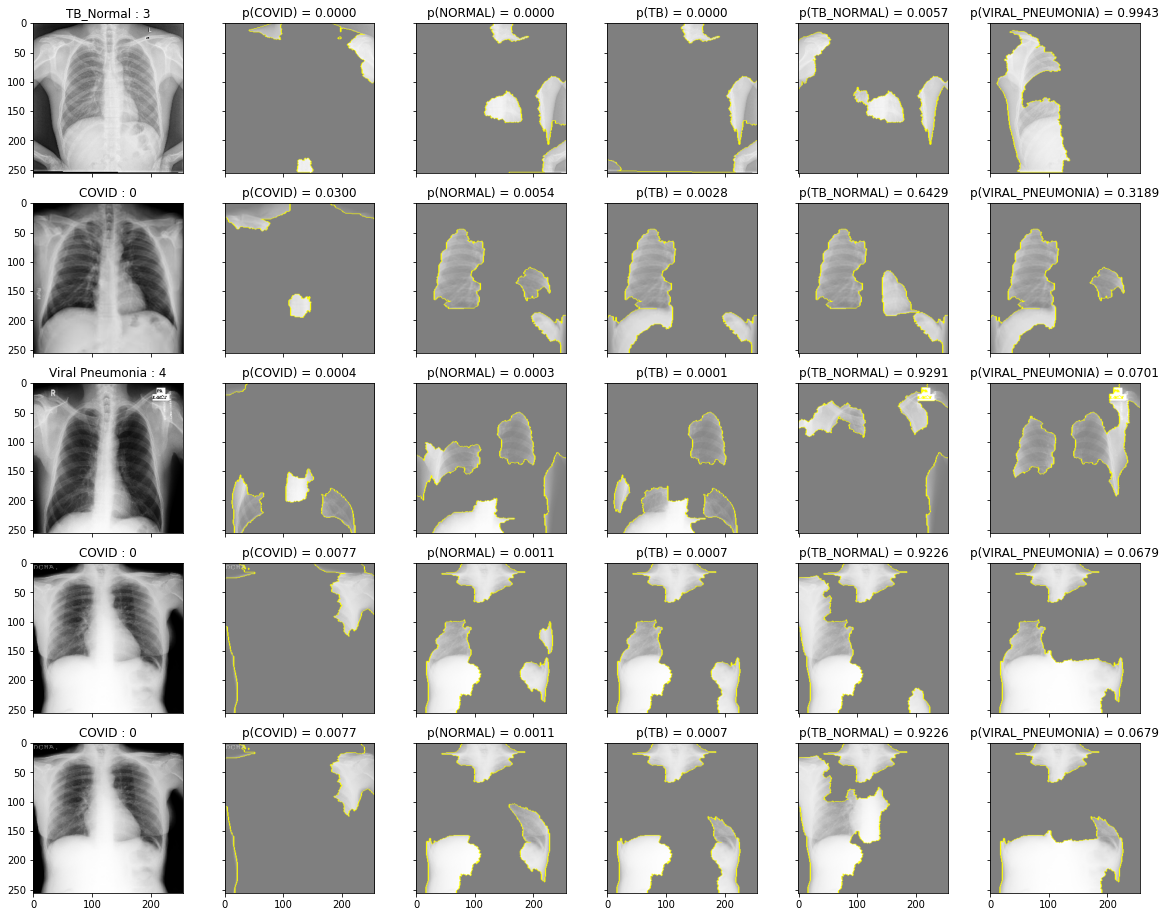

In [95]:
bad_pred_lime(model_m4,X_test,y_test)

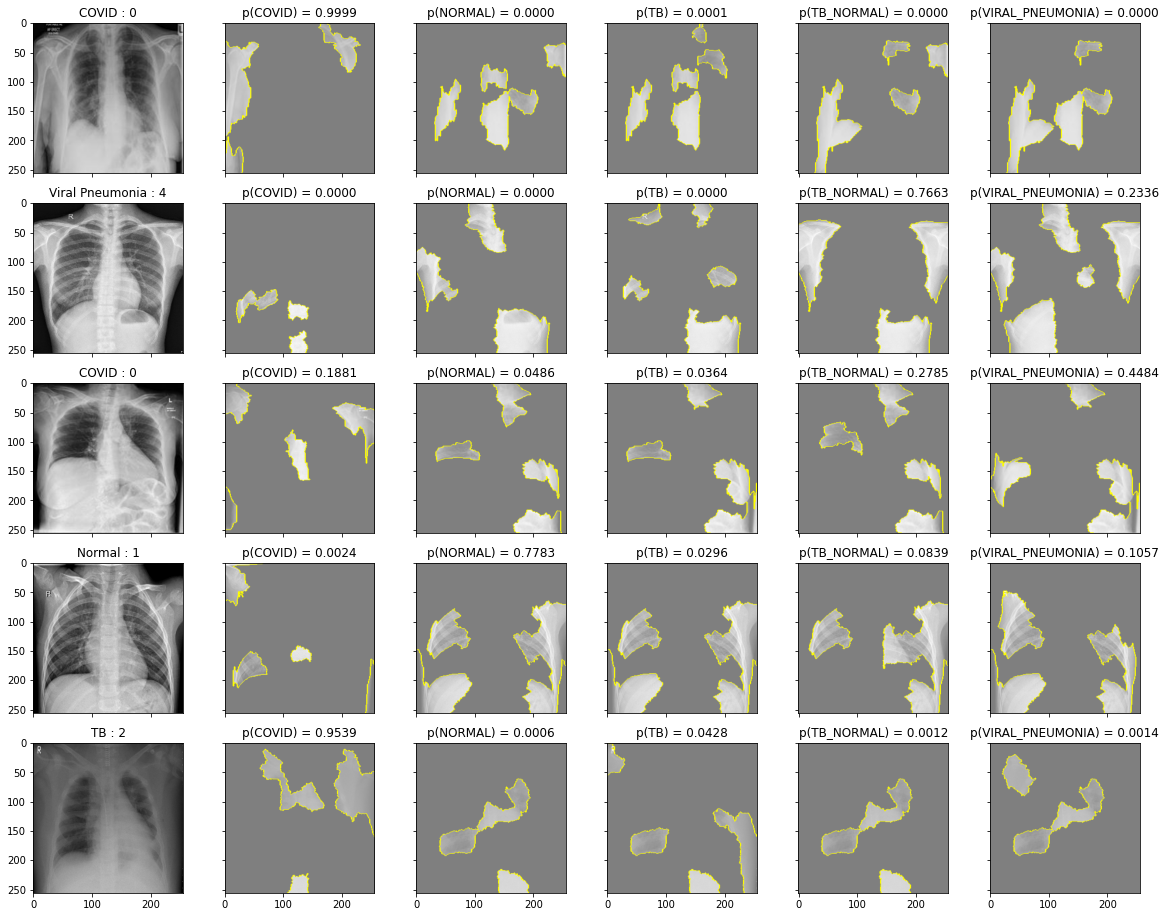

In [96]:
lime(model_m4,X_test,y_test)

#### Model 3d

Layers: 4\
Optimizer Adam\
LeakyReLu Present

In [92]:
model_vgg16_LR = transfer_model(conv_base_vgg16,dense_layers={1:3000,2:1500,3:500,4:256},LeakyReLU=True)

In [93]:
hist_vgg16_LR = train_model(model_vgg16_LR,X_train,y_train)

Epoch 1/50
60/60 [==============================] - 22s 359ms/step - loss: 4.0827 - acc: 0.4798 - val_loss: 0.3286 - val_acc: 0.8863
Epoch 2/50
60/60 [==============================] - 21s 357ms/step - loss: 0.2937 - acc: 0.9208 - val_loss: 0.2609 - val_acc: 0.8934
Epoch 3/50
60/60 [==============================] - 21s 355ms/step - loss: 0.2572 - acc: 0.9358 - val_loss: 0.2094 - val_acc: 0.9194
Epoch 4/50
60/60 [==============================] - 21s 355ms/step - loss: 0.1487 - acc: 0.9664 - val_loss: 0.2046 - val_acc: 0.9218
Epoch 5/50
60/60 [==============================] - 21s 354ms/step - loss: 0.1485 - acc: 0.9613 - val_loss: 0.1789 - val_acc: 0.9360
Epoch 6/50
60/60 [==============================] - 21s 355ms/step - loss: 0.1006 - acc: 0.9774 - val_loss: 0.1179 - val_acc: 0.9550
Epoch 7/50
60/60 [==============================] - 21s 355ms/step - loss: 0.1129 - acc: 0.9778 - val_loss: 0.1741 - val_acc: 0.9360
Epoch 8/50
60/60 [==============================] - 21s 354ms/step - 

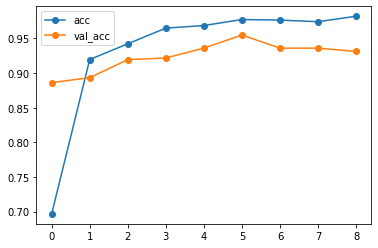

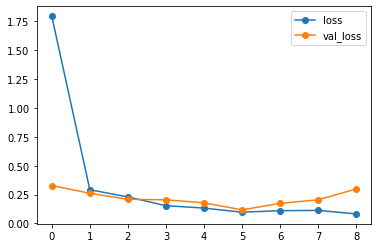

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       127
           1       0.98      0.99      0.98       132
           2       0.98      0.98      0.98       128
           3       0.94      0.80      0.86        40
           4       0.82      0.95      0.88        42

    accuracy                           0.96       469
   macro avg       0.94      0.94      0.94       469
weighted avg       0.97      0.96      0.96       469



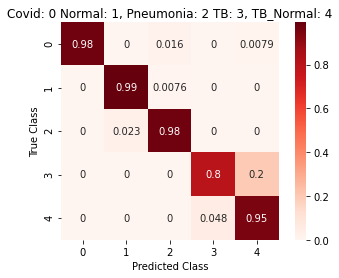

In [94]:
performance_plot(model_vgg16_LR,hist_vgg16_LR,X_test,y_test)

Bad predictions: 17


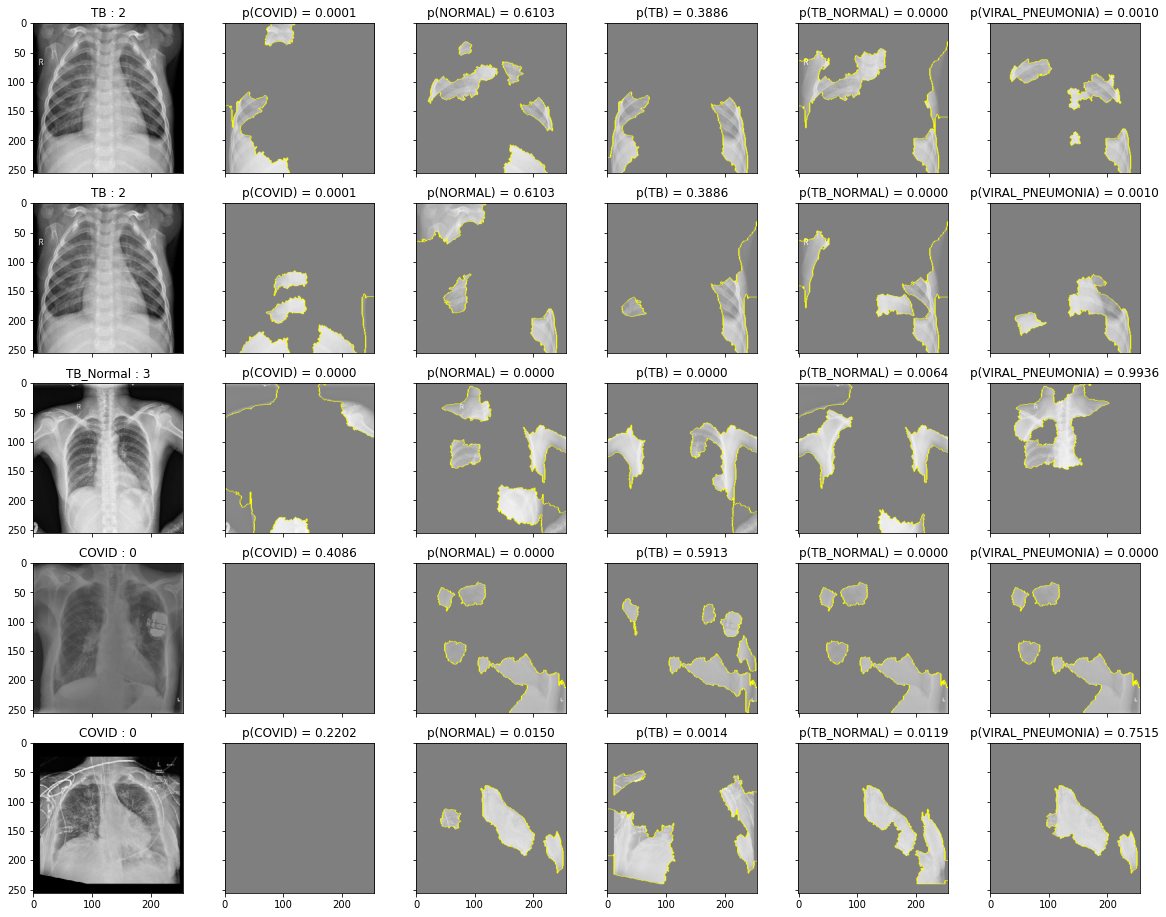

In [98]:
bad_pred_lime(model_vgg16_LR,X_test,y_test)

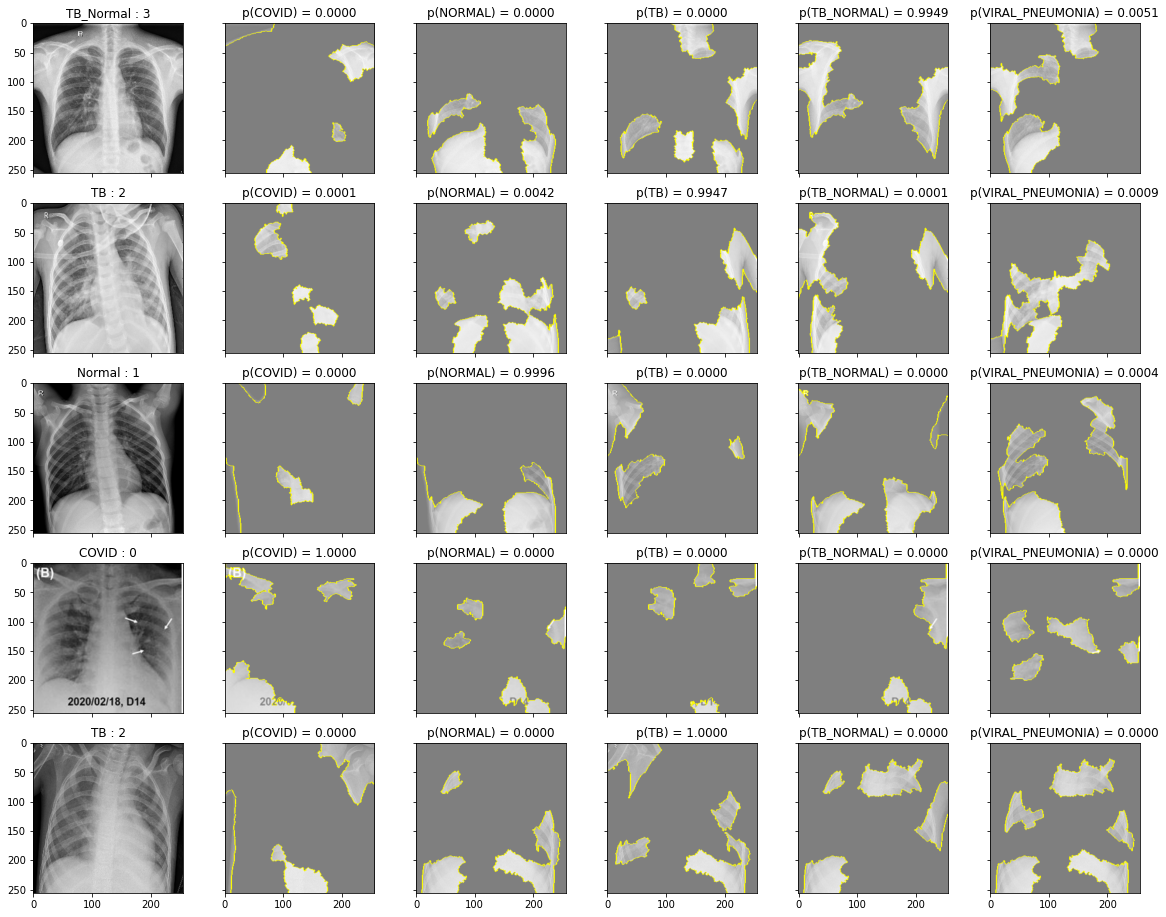

In [99]:
lime(model_vgg16_LR,X_test,y_test)

## Pre-trained Model Xception

In [40]:
conv_base_xception = conv_base(base_model='Xception')

### Xception Model 1

Layers: 4\
Optimizer: Adam\
LeakyReLu Present\
Dropout Present\
Class weights considered

In [45]:
model_xception_m1= transfer_model(conv_base_xception,dense_layers={1:3000,2:1500,3:500,4:256},LeakyReLU=True,Dropout=True)

In [46]:
hist_xception_m1 = train_model(model_xception_m1,X_train,y_train)

Epoch 1/50
60/60 [==============================] - 38s 466ms/step - loss: 17.0417 - acc: 0.4800 - val_loss: 0.4567 - val_acc: 0.8555
Epoch 2/50
60/60 [==============================] - 27s 452ms/step - loss: 0.5927 - acc: 0.8604 - val_loss: 0.3210 - val_acc: 0.8744
Epoch 3/50
60/60 [==============================] - 28s 463ms/step - loss: 0.4780 - acc: 0.8727 - val_loss: 0.2542 - val_acc: 0.9100
Epoch 4/50
60/60 [==============================] - 27s 454ms/step - loss: 0.3402 - acc: 0.9097 - val_loss: 0.2453 - val_acc: 0.9171
Epoch 5/50
60/60 [==============================] - 27s 454ms/step - loss: 0.3359 - acc: 0.9117 - val_loss: 0.2477 - val_acc: 0.8981
Epoch 6/50
60/60 [==============================] - 27s 458ms/step - loss: 0.2877 - acc: 0.9279 - val_loss: 0.2705 - val_acc: 0.9028
Epoch 7/50
60/60 [==============================] - 27s 457ms/step - loss: 0.2601 - acc: 0.9315 - val_loss: 0.2813 - val_acc: 0.9194


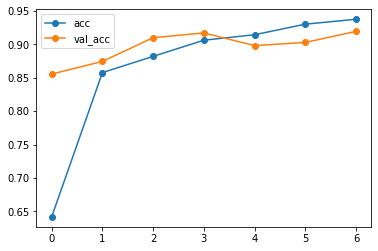

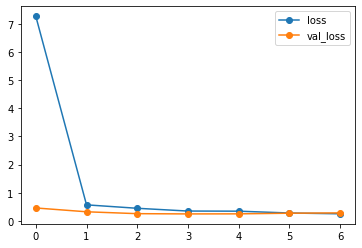

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       127
           1       0.94      0.98      0.96       132
           2       0.98      0.90      0.94       128
           3       0.77      0.90      0.83        40
           4       0.89      0.79      0.84        42

    accuracy                           0.94       469
   macro avg       0.91      0.91      0.91       469
weighted avg       0.94      0.94      0.94       469



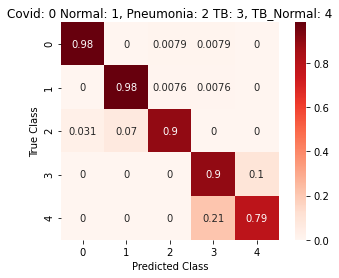

In [47]:
performance_plot(model_xception_m1,hist_xception_m1,X_test,y_test)

### Xception Model 2

Layers: 4\
Optimizer: RMSProp\
LeakyReLu and Dropout present

In [41]:
model_xception_m2= transfer_model(conv_base_xception,dense_layers={1:3000,2:1500,3:500,4:256},
                                  optimizer='RMSprop',LeakyReLU=True,Dropout=True)

In [42]:
hist_xception_m2 = train_model(model_xception_m2,X_train,y_train)

Epoch 1/50
60/60 [==============================] - 43s 536ms/step - loss: 75.2867 - acc: 0.4868 - val_loss: 0.9574 - val_acc: 0.7773
Epoch 2/50
60/60 [==============================] - 31s 519ms/step - loss: 0.9386 - acc: 0.7950 - val_loss: 0.8210 - val_acc: 0.7867
Epoch 3/50
60/60 [==============================] - 32s 539ms/step - loss: 0.7615 - acc: 0.8043 - val_loss: 0.3936 - val_acc: 0.8815
Epoch 4/50
60/60 [==============================] - 32s 532ms/step - loss: 0.5278 - acc: 0.8788 - val_loss: 0.3959 - val_acc: 0.8507
Epoch 5/50
60/60 [==============================] - 32s 530ms/step - loss: 0.4729 - acc: 0.8897 - val_loss: 0.2870 - val_acc: 0.9123
Epoch 6/50
60/60 [==============================] - 32s 533ms/step - loss: 0.4204 - acc: 0.9132 - val_loss: 0.3242 - val_acc: 0.8957
Epoch 7/50
60/60 [==============================] - 32s 532ms/step - loss: 0.3370 - acc: 0.9114 - val_loss: 0.4678 - val_acc: 0.8791
Epoch 8/50
60/60 [==============================] - 32s 530ms/step -

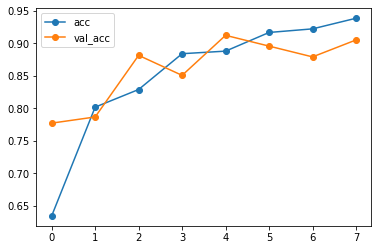

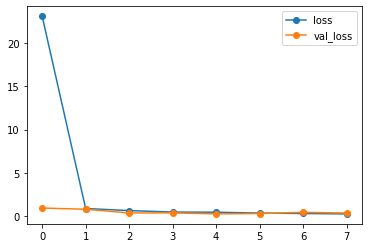

              precision    recall  f1-score   support

           0       0.94      0.99      0.97       127
           1       0.90      0.99      0.94       132
           2       0.99      0.85      0.92       128
           3       0.59      0.95      0.73        40
           4       0.93      0.33      0.49        42

    accuracy                           0.89       469
   macro avg       0.87      0.82      0.81       469
weighted avg       0.91      0.89      0.88       469



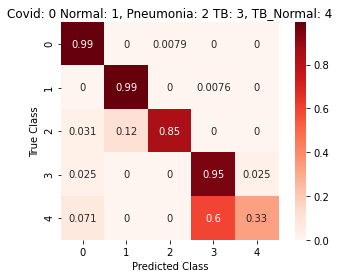

In [43]:
performance_plot(model_xception_m2,hist_xception_m2,X_test,y_test)

## Pretrained Model DenseNet121

In [44]:
conv_base_dnet = conv_base(base_model='DenseNet121')

### DenseNet121 Model 1

In [45]:
model_dnet_m1 = transfer_model(conv_base_dnet,dense_layers={1:3000,2:1500,3:500,4:256},LeakyReLU=True,Dropout=True)

In [46]:
hist_dnet_m1 = train_model(model_dnet_m1,X_train,y_train)

Epoch 1/50
60/60 [==============================] - 29s 426ms/step - loss: 4.0688 - acc: 0.3623 - val_loss: 0.4127 - val_acc: 0.8199
Epoch 2/50
60/60 [==============================] - 22s 364ms/step - loss: 0.3964 - acc: 0.8886 - val_loss: 0.1805 - val_acc: 0.9218
Epoch 3/50
60/60 [==============================] - 21s 353ms/step - loss: 0.3107 - acc: 0.9147 - val_loss: 0.2012 - val_acc: 0.9194
Epoch 4/50
60/60 [==============================] - 21s 354ms/step - loss: 0.2418 - acc: 0.9362 - val_loss: 0.3486 - val_acc: 0.8768
Epoch 5/50
60/60 [==============================] - 22s 361ms/step - loss: 0.2432 - acc: 0.9320 - val_loss: 0.1302 - val_acc: 0.9479
Epoch 6/50
60/60 [==============================] - 22s 363ms/step - loss: 0.1851 - acc: 0.9576 - val_loss: 0.1869 - val_acc: 0.9265
Epoch 7/50
60/60 [==============================] - 21s 359ms/step - loss: 0.2067 - acc: 0.9453 - val_loss: 0.1341 - val_acc: 0.9455
Epoch 8/50
60/60 [==============================] - 21s 357ms/step - 

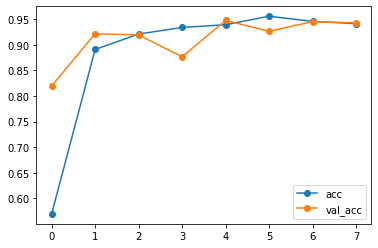

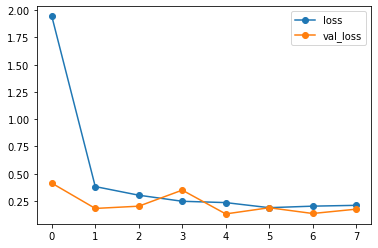

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       127
           1       0.96      0.99      0.98       132
           2       0.99      0.95      0.97       128
           3       0.77      0.85      0.81        40
           4       0.83      0.83      0.83        42

    accuracy                           0.95       469
   macro avg       0.91      0.92      0.91       469
weighted avg       0.95      0.95      0.95       469



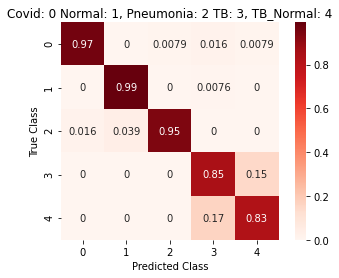

In [47]:
performance_plot(model_dnet_m1,hist_dnet_m1,X_test,y_test)

Bad predictions: 25


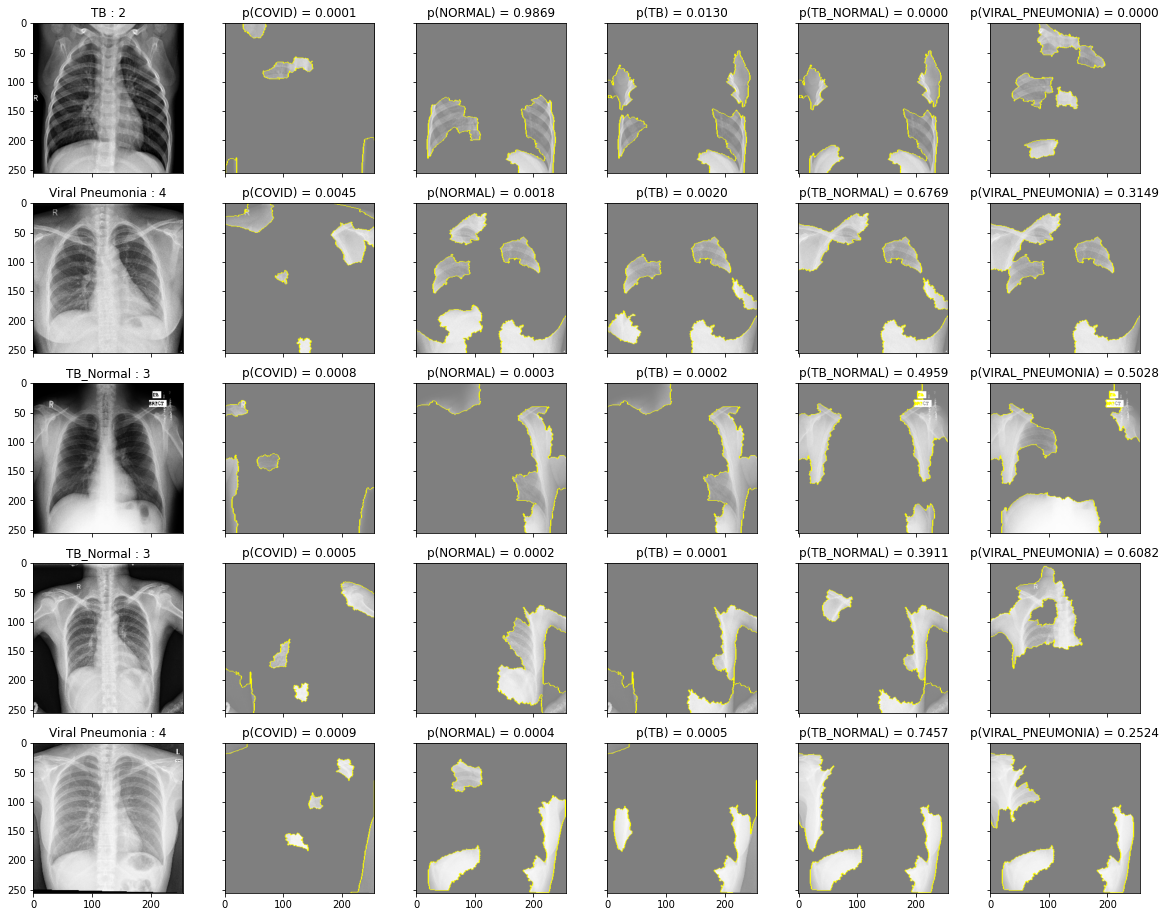

In [48]:
bad_pred_lime(model_dnet_m1,X_test,y_test)

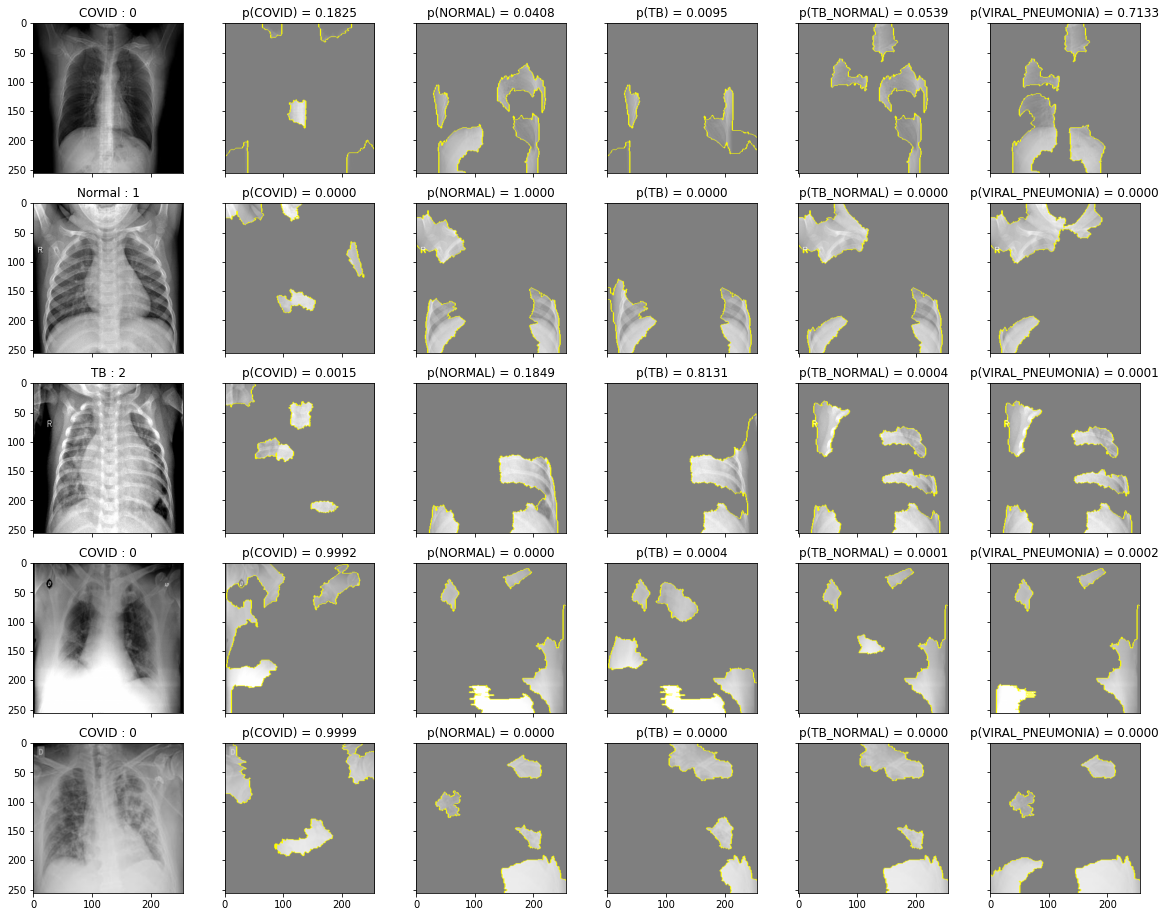

In [49]:
lime(model_dnet_m1,X_test,y_test)

## Recommendations

- With acceptabley high accuracy of more than 95%, and high precision and recall for covid and pneumonia patients, it is recommended to consider using an AI based model for accurate diagnosis.

- Looking at comparatively lower accuracy, precision and recall with TB patients, it is recommended to invest in further research in gathering more data and building further on the model to be able to use the model to detect TB.

- Although the model shows high accuracy, it is important and recommended to use a combination of other symptoms either by knowledge or integrating it with the model for better diagnosis and patient care.

## Future Work

- Building a Dashboard/Application that would accept any format of the Xray, preprocess and use the model for diagnosis, and include the area of the X-ray used for the result (explaination)

- Explore other models by building by scratch, and including image augmentation to improve the predictability of the model

- Include other symptoms in the model to aid in better diagnosis

## References

[1] https://towardsdatascience.com/detecting-covid-19-induced-pneumonia-from-chest-x-rays-with-transfer-learning-an-implementation-311484e6afc1

[2] Aiyesha Sadiya, Anusha V Illur, Aekhata Nanda, Eshwar Rao, Vidyashree K P, Mansoor Ahmed. *Differential Diagnosis of Tuberculosis and
Pneumonia using Machine Learning*